# Дообучение сегментатора на полных изображениях

In [43]:
from model import RootRegressor
from dataset import RootVolumeDataset
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import random
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
%matplotlib inline

In [17]:
def nearest_power_of_2(n):
    return 2 ** int(np.ceil(np.log2(n)))

def find_max_slice(csv_path):
    df = pd.read_csv(csv_path)
    return nearest_power_of_2(np.max(df["End"] - df["Start"]) + 1)

def get_params():
    size_file = open("target_size.txt", "r")
    width, height = [int(line.replace("\n", "").split(" ")[-1]) for line in size_file.readlines()]
    params = {}
    params["width"] = width
    params["height"] = height
    params["max_slices"] = find_max_slice("Train.csv")
    return params

In [18]:
params = get_params()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_path = "Train.csv"
img_path = "images/train/"
dataset = RootVolumeDataset(csv_path=train_path,
                            img_root=img_path,
                            target_width=params['width'],
                            target_height=params['height'],
                            label_root="train_labels/",
                            device=device,
                            pre_segment=False,
                            full_img=False)

In [19]:
print(dataset[0]["images"])

[<PIL.Image.Image image mode=RGB size=908x14 at 0x120BD751CF0>, <PIL.Image.Image image mode=RGB size=908x14 at 0x120BD779C60>, <PIL.Image.Image image mode=RGB size=908x14 at 0x120BD779FF0>, <PIL.Image.Image image mode=RGB size=908x14 at 0x120BD77A140>, <PIL.Image.Image image mode=RGB size=908x14 at 0x120FC6B5B40>, <PIL.Image.Image image mode=RGB size=908x14 at 0x120A17D75B0>, <PIL.Image.Image image mode=RGB size=908x14 at 0x120A17D7A60>, <PIL.Image.Image image mode=RGB size=908x14 at 0x120A17D40D0>, <PIL.Image.Image image mode=RGB size=908x14 at 0x120A17D6CB0>, <PIL.Image.Image image mode=RGB size=908x14 at 0x120A17D4AC0>]


In [20]:
imgs = dataset[23]["images"]
for image in imgs:
    display(image)

In [25]:
def stack_images_vertically(images : list[Image]):
    widths, heights = zip(*(i.size for i in images))
    min_width = min(widths)
    total_height = sum(heights)
    stacked_image = Image.new("RGB", (min_width, total_height))
    y_offset = 0
    for img in images:
        if img.width > min_width:
            img = img.crop((0, 0, min_width, img.height))
        stacked_image.paste(img,(0, y_offset))
        y_offset += img.height
    return stacked_image

In [26]:
def generate_random_color():
    """Generate a bright, random color."""
    return tuple(random.randint(100, 255) for _ in range(3))  # RGB values

def prepare_stacked_data(image_paths, label_paths):
    """
    Prepare a stacked image and combined mask string from matching image-label pairs.

    Args:
        image_paths (list): List of paths to image files.
        label_paths (list): List of paths to label files.

    Returns:
        tuple: (stacked_image, combined_masks_str)
            - stacked_image: PIL Image object of the stacked images.
            - combined_masks_str: String combining all mask annotations.
    """
    # Create a dictionary mapping label base names to their full paths
    label_map = {os.path.splitext(os.path.basename(lf))[0]: lf for lf in label_paths}
    matching_images = []
    matching_labels = []

    # Match images with corresponding labels
    for image_path in image_paths:
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        if image_name in label_map:
            matching_images.append(image_path)
            matching_labels.append(label_map[image_name])


    # Load and stack the matching images
    images = [Image.open(path) for path in matching_images]
    if len(images) == 0:
        images = [Image.open(path) for path in image_paths]
    widths, heights = zip(*(i.size for i in images))
    min_width = min(widths)
    total_height = sum(heights)

    # Stack images vertically
    stacked_image = Image.new('RGB', (min_width, total_height))
    y_offset = 0
    for im in images:
        im_resized = im.resize((min_width, im.height))
        stacked_image.paste(im_resized, (0, y_offset))
        y_offset += im.height

    # Handle case where no matching pairs are found
    if not matching_images:
        print("No matching image-label pairs found. Just return the image")
        return stacked_image, ""

    # Combine masks with adjusted coordinates
    combined_mask_lines = []
    cumulative_height = 0
    for label_path, im_height, im_width in zip(matching_labels, heights, widths):
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) < 3:
                    continue
                class_id = parts[0]
                coords = list(map(float, parts[1:]))
                new_coords = []
                for x_norm, y_norm in zip(coords[0::2], coords[1::2]):
                    x_pixel = int(x_norm * im_width)
                    y_pixel = int(y_norm * im_height)
                    x_pixel_cropped = min(x_pixel, min_width - 1)
                    y_pixel_offset = y_pixel + cumulative_height
                    new_x_norm = x_pixel_cropped / min_width
                    new_y_norm = y_pixel_offset / total_height
                    new_coords.extend([new_x_norm, new_y_norm])
                new_line = class_id + " " + " ".join(f"{val:.6f}" for val in new_coords)
                combined_mask_lines.append(new_line)
        cumulative_height += im_height
    combined_masks_str = "\n".join(combined_mask_lines)

    return stacked_image, combined_masks_str

def get_polygons_from_mask_str(mask_str, img_width, img_height):
    polygons = []
    # Split into lines (each line is a polygon)
    lines = mask_str.strip().split('\n') 
    for line in lines:
        # Split line into parts (class ID and coordinates)
        parts = line.strip().split()
        if len(parts) < 3:  # Need at least class ID + one (x, y) pair
            continue
        # Convert coordinates to floats, skipping the class ID
        coords = list(map(float, parts[1:]))
        if len(coords) % 2 != 0:  # Must have even number for (x, y) pairs
            continue
        # Group into (x, y) pairs and convert to pixel coordinates
        points = [(int(x * img_width), int(y * img_height)) 
                  for x, y in zip(coords[0::2], coords[1::2])]
        # Convert to NumPy array and append to list
        polygons.append(np.array(points, dtype=np.int32))
    return polygons
def visualize(stacked_image, polygons):
    # Visualize with polygons
    image = np.array(stacked_image)
    for polygon in polygons:
        if polygon.shape[0]:
            color = generate_random_color()
            cv2.polylines(image, [polygon.astype(int)], isClosed=True, color=color, thickness=1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Обучение

In [27]:
train = pd.read_csv("Train.csv")
output = "seg/images"
os.makedirs(output,exist_ok=True)
os.makedirs(output.replace('images', 'labels'), exist_ok=True)

In [28]:
def get_images_labels(folder_name):
    """Retrieve sorted lists of label and image file paths for a given folder."""
    labels = glob(f'train_labels/{folder_name}*')
    labels = sorted(labels)
    imgs = glob(f'images/train/{folder_name.split("_")[0]}/{folder_name}*')
    imgs = sorted(imgs)
    return labels, imgs

## Подготовим изображения и маски

In [29]:
for f in tqdm(train.FolderName.unique()):
    for side in ['L', 'R']:
        labels, imgs = get_images_labels(f'{f}_{side}_')
        if imgs and labels:
            stacked_image, mask_str = prepare_stacked_data(imgs, labels)
            output_path = f'{output}/{f}_{side}.png'
            stacked_image.save(output_path)
            with open(output_path.replace('images', 'labels').replace('.png', '.txt'), 'w') as fx:
                fx.write(mask_str)


100%|██████████| 98/98 [00:08<00:00, 11.46it/s]


## YOLO

In [30]:
from ultralytics import YOLO

In [34]:
yaml_content = """
path: D:/python/manioka/seg
train: images
val: images
names:
    0: root
"""
with open(f'./seg/config.yaml', 'w') as f:
    f.write(yaml_content.strip())

# 3. Train the Model on Combined Images
model = YOLO("yolo11l-seg.pt")
model.train(data=f"./seg/config.yaml", epochs=100, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.96  Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
engine\trainer: task=segment, mode=train, model=yolo11l-seg.pt, data=./seg/config.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fals

100%|██████████| 755k/755k [00:00<00:00, 4.13MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              


  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  2   1455616  ultralytics.nn.modules.block.C2PSA           [512, 512, 2]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   2496512  ultralytics.nn.modules.block.C3k2            [1024, 512, 2, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

100%|██████████| 5.35M/5.35M [00:00<00:00, 8.04MB/s]


AMP: checks passed 


train: Scanning D:\python\manioka\seg\labels... 47 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47/47 [00:00<00:00, 308.38it/s]

train: New cache created: D:\python\manioka\seg\labels.cache



val: Scanning D:\python\manioka\seg\labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47/47 [00:00<?, ?it/s]


Plotting labels to runs\segment\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\segment\train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      12.9G      4.752       5.83      3.865      2.129       1020        640: 100%|██████████| 3/3 [00:35<00:00, 11.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

                   all         47       1964   0.000238    0.00102   0.000121    2.4e-05   0.000713    0.00305   0.000362   0.000177



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100        13G      5.048      6.164      4.273      2.217        843        640: 100%|██████████| 3/3 [00:26<00:00,  8.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         47       1964   0.000958    0.00407   0.000487   0.000158    0.00168    0.00713   0.000847    0.00034



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.4G      4.689      5.624      3.881      2.127       1095        640: 100%|██████████| 3/3 [00:30<00:00, 10.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

                   all         47       1964    0.00192    0.00815    0.00179   0.000515    0.00276     0.0117     0.0014     0.0007



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100        13G      5.007       6.18      4.019      2.317        720        640: 100%|██████████| 3/3 [00:25<00:00,  8.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         47       1964    0.00305     0.0132    0.00203   0.000713    0.00446     0.0193    0.00227    0.00109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.1G      4.009      6.389      3.344      1.677       1169        640: 100%|██████████| 3/3 [00:29<00:00,  9.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         47       1964      0.355      0.311      0.222     0.0614      0.176      0.227     0.0888     0.0378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.2G      3.045       4.43      2.364      1.188        661        640: 100%|██████████| 3/3 [00:33<00:00, 11.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         47       1964       0.15      0.421     0.0996     0.0308      0.127       0.39     0.0926     0.0399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.3G      2.969      3.353      2.333      1.181        879        640: 100%|██████████| 3/3 [00:32<00:00, 10.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         47       1964      0.321      0.201      0.138     0.0387       0.18      0.115     0.0525      0.021



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.5G        2.4      3.051      1.552      1.065       1051        640: 100%|██████████| 3/3 [00:38<00:00, 12.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]

                   all         47       1964      0.335      0.194      0.142     0.0412      0.153      0.134     0.0501     0.0195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.3G      2.533      3.631      1.554      1.044        837        640: 100%|██████████| 3/3 [00:30<00:00, 10.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         47       1964      0.131      0.235     0.0629      0.016      0.109      0.235     0.0555     0.0224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.2G      2.626      3.751      1.541      1.057        896        640: 100%|██████████| 3/3 [00:28<00:00,  9.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         47       1964      0.195      0.274     0.0989     0.0264      0.119       0.24     0.0621     0.0262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.5G      2.527      2.939      1.533      1.048        811        640: 100%|██████████| 3/3 [00:28<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         47       1964      0.166      0.333     0.0845     0.0274     0.0893      0.227     0.0447      0.021



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.2G      2.317      2.736      1.397      1.033       1089        640: 100%|██████████| 3/3 [00:28<00:00,  9.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         47       1964      0.171      0.282     0.0813     0.0234      0.103      0.202     0.0527     0.0258



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.4G      2.268      2.893       1.34      1.044        905        640: 100%|██████████| 3/3 [00:54<00:00, 18.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

                   all         47       1964      0.127      0.143     0.0433     0.0132     0.0961      0.136     0.0386     0.0179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.3G      2.264      3.044      1.289     0.9922        824        640: 100%|██████████| 3/3 [00:39<00:00, 13.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         47       1964      0.125     0.0759     0.0351     0.0116     0.0587     0.0489     0.0203    0.00887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.1G      2.351      2.876      1.288      1.028        882        640: 100%|██████████| 3/3 [00:43<00:00, 14.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]

                   all         47       1964     0.0473     0.0499      0.013    0.00324     0.0741     0.0621     0.0209    0.00921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.2G      2.405      2.838      1.387      1.071        922        640: 100%|██████████| 3/3 [00:34<00:00, 11.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         47       1964       0.14      0.164     0.0513     0.0151      0.125      0.153     0.0494     0.0236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.4G      2.198      2.759       1.29      1.015        978        640: 100%|██████████| 3/3 [00:56<00:00, 18.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]

                   all         47       1964       0.18     0.0978       0.04     0.0121      0.115      0.117     0.0449     0.0225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.2G      2.213      2.692      1.302     0.9806        705        640: 100%|██████████| 3/3 [00:41<00:00, 13.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         47       1964     0.0516    0.00967     0.0115    0.00544     0.0561     0.0153     0.0173    0.00939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.2G      2.188      2.749      1.301     0.9986        797        640: 100%|██████████| 3/3 [00:34<00:00, 11.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         47       1964     0.0811     0.0102    0.00824    0.00233     0.0631     0.0143     0.0112    0.00559



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.5G      2.065      2.464       1.19      1.013        925        640: 100%|██████████| 3/3 [00:28<00:00,  9.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         47       1964      0.159    0.00102    0.00781    0.00273      0.159    0.00102    0.00781    0.00352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.2G      2.197      2.629      1.154     0.9849        943        640: 100%|██████████| 3/3 [00:37<00:00, 12.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         47       1964          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.2G      2.212      2.657      1.175     0.9928        871        640: 100%|██████████| 3/3 [00:34<00:00, 11.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         47       1964     0.0333    0.00153     0.0215     0.0108     0.0666    0.00204      0.027     0.0193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      13.3G       2.04      2.455      1.158     0.9613        867        640: 100%|██████████| 3/3 [00:30<00:00, 10.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         47       1964      0.187     0.0524     0.0349      0.016      0.126     0.0418     0.0286     0.0147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.3G      2.011      2.694       1.08     0.9911        798        640: 100%|██████████| 3/3 [00:30<00:00, 10.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         47       1964          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      13.2G      2.039      2.504      1.033      0.959        962        640: 100%|██████████| 3/3 [00:26<00:00,  8.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         47       1964          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.2G      2.029      2.527      1.114      1.014        934        640: 100%|██████████| 3/3 [00:35<00:00, 11.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         47       1964          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.6G      2.016       2.31      1.072     0.9729       1161        640: 100%|██████████| 3/3 [00:28<00:00,  9.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         47       1964      0.139    0.00356     0.0114    0.00654      0.139    0.00356     0.0114    0.00869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.3G      1.983      2.381      1.053     0.9541        858        640: 100%|██████████| 3/3 [00:25<00:00,  8.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         47       1964     0.0347     0.0148    0.00791    0.00316     0.0383     0.0163     0.0098    0.00496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.2G      1.979      2.312      1.026     0.9665        974        640: 100%|██████████| 3/3 [00:27<00:00,  9.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         47       1964     0.0347     0.0148    0.00791    0.00316     0.0383     0.0163     0.0098    0.00496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.4G      2.026      2.415      1.043      1.003        767        640: 100%|██████████| 3/3 [00:37<00:00, 12.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]

                   all         47       1964      0.393      0.303      0.222     0.0811        0.2      0.193     0.0863     0.0349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.5G      1.951      2.369     0.9876     0.9626       1134        640: 100%|██████████| 3/3 [00:35<00:00, 11.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

                   all         47       1964      0.434       0.47       0.31      0.116      0.212      0.259      0.108     0.0423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.4G      1.844       2.36     0.9846      0.955        910        640: 100%|██████████| 3/3 [00:37<00:00, 12.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all         47       1964      0.582       0.45      0.396       0.16      0.343      0.299      0.182     0.0781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.4G      1.979      2.399     0.9895      0.947       1150        640: 100%|██████████| 3/3 [00:32<00:00, 10.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         47       1964      0.582       0.45      0.396       0.16      0.343      0.299      0.182     0.0781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.3G      1.946      2.319      1.042     0.9588        890        640: 100%|██████████| 3/3 [00:32<00:00, 10.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]

                   all         47       1964      0.572      0.398      0.387      0.159      0.285      0.273      0.152      0.064



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.3G      1.959      2.287      1.084      0.979        711        640: 100%|██████████| 3/3 [00:32<00:00, 10.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         47       1964      0.491      0.325      0.324      0.134       0.23      0.229      0.126     0.0571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.3G      1.929       2.28       1.07     0.9631        925        640: 100%|██████████| 3/3 [00:41<00:00, 13.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         47       1964       0.39      0.225      0.215     0.0901      0.171      0.148      0.078     0.0342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.3G      1.858      2.195      1.108     0.9526       1023        640: 100%|██████████| 3/3 [00:34<00:00, 11.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         47       1964       0.39      0.225      0.215     0.0901      0.171      0.148      0.078     0.0342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.4G      1.905      2.347      1.036      0.953        939        640: 100%|██████████| 3/3 [00:36<00:00, 12.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         47       1964      0.436      0.218      0.218     0.0911      0.174      0.177     0.0978     0.0413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.3G      1.923      2.281     0.9926     0.9552       1240        640: 100%|██████████| 3/3 [00:35<00:00, 11.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         47       1964      0.499      0.305      0.312      0.131       0.22      0.171      0.109     0.0488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.4G      1.854      2.324      1.086     0.9905        867        640: 100%|██████████| 3/3 [01:08<00:00, 22.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]

                   all         47       1964      0.497      0.299      0.295      0.124       0.23      0.214      0.127     0.0586



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.4G      1.824      2.227     0.9843      0.966        940        640: 100%|██████████| 3/3 [00:32<00:00, 10.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         47       1964      0.497      0.299      0.295      0.124       0.23      0.214      0.127     0.0586



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.6G      1.902      2.176      1.009     0.9683        944        640: 100%|██████████| 3/3 [00:36<00:00, 12.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]

                   all         47       1964      0.587      0.452       0.44      0.178      0.367      0.354      0.256      0.119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.4G      1.935      2.186       1.04     0.9819        945        640: 100%|██████████| 3/3 [00:33<00:00, 11.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

                   all         47       1964      0.617      0.502      0.506      0.245      0.333      0.341      0.232      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.5G      1.906       2.15      1.062     0.9379        992        640: 100%|██████████| 3/3 [00:29<00:00,  9.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         47       1964       0.71      0.498      0.567       0.26      0.333      0.344      0.222     0.0938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.2G      1.893      2.231     0.9771     0.9482       1120        640: 100%|██████████| 3/3 [00:32<00:00, 10.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

                   all         47       1964       0.71      0.498      0.567       0.26      0.333      0.344      0.222     0.0938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.3G      1.862      2.258     0.9961     0.9505       1005        640: 100%|██████████| 3/3 [00:39<00:00, 13.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         47       1964       0.67      0.465      0.517      0.229      0.331      0.354      0.233        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.4G      1.837       2.19     0.9703     0.9296       1152        640: 100%|██████████| 3/3 [00:34<00:00, 11.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         47       1964      0.672      0.462      0.526      0.248      0.326      0.345      0.233      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.3G      1.807      2.171     0.9504     0.9585        934        640: 100%|██████████| 3/3 [00:52<00:00, 17.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all         47       1964      0.654      0.474      0.518      0.249      0.325      0.255      0.185     0.0792



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.2G      1.832      2.192     0.9739     0.9717        998        640: 100%|██████████| 3/3 [00:34<00:00, 11.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         47       1964      0.654      0.474      0.518      0.249      0.325      0.255      0.185     0.0792



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.5G      1.858      2.103     0.9387     0.9529        917        640: 100%|██████████| 3/3 [00:33<00:00, 11.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]

                   all         47       1964       0.72      0.481      0.544      0.249      0.397      0.319      0.251      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      13.4G      1.828      2.204     0.9655      0.944        856        640: 100%|██████████| 3/3 [00:36<00:00, 12.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]

                   all         47       1964      0.702       0.54      0.593      0.284      0.357      0.304      0.222     0.0951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      13.3G      1.799       2.09      1.016     0.9519        943        640: 100%|██████████| 3/3 [00:38<00:00, 12.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]

                   all         47       1964       0.67      0.537      0.575      0.266      0.275      0.225      0.135     0.0535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      13.4G      1.821      2.149     0.9778     0.9309        906        640: 100%|██████████| 3/3 [00:32<00:00, 10.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         47       1964       0.67      0.537      0.575      0.266      0.275      0.225      0.135     0.0535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      13.4G      1.648       1.92     0.9396     0.9482       1034        640: 100%|██████████| 3/3 [00:38<00:00, 12.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]

                   all         47       1964      0.665      0.555      0.592      0.279       0.28      0.242      0.148     0.0583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      13.4G      1.784      2.181     0.9728     0.9383        660        640: 100%|██████████| 3/3 [00:37<00:00, 12.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

                   all         47       1964      0.736      0.554      0.629      0.313      0.387       0.31       0.23     0.0963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      13.6G      1.902      2.221     0.9488     0.9112        930        640: 100%|██████████| 3/3 [00:36<00:00, 12.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         47       1964      0.703      0.552       0.61      0.301      0.379      0.322      0.241     0.0991



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.3G      1.949      2.229      1.087     0.9351        737        640: 100%|██████████| 3/3 [00:29<00:00,  9.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         47       1964      0.703      0.552       0.61      0.301      0.379      0.322      0.241     0.0991



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      13.2G        1.7      2.103     0.9161     0.9203       1086        640: 100%|██████████| 3/3 [00:25<00:00,  8.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

                   all         47       1964      0.677      0.543      0.585      0.288      0.334      0.286      0.203     0.0835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.3G      1.657       2.07     0.8953     0.9185        904        640: 100%|██████████| 3/3 [00:30<00:00, 10.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         47       1964      0.681      0.562      0.604       0.28      0.283       0.31      0.191     0.0816



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      13.2G       1.62      2.098     0.8709     0.9127       1002        640: 100%|██████████| 3/3 [00:39<00:00, 13.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         47       1964      0.678      0.597      0.631      0.306      0.344      0.352      0.254      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      13.3G      1.625      1.955     0.8941     0.9501        971        640: 100%|██████████| 3/3 [00:25<00:00,  8.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         47       1964      0.678      0.597      0.631      0.306      0.344      0.352      0.254      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      13.3G      1.614      2.068     0.8691     0.9181       1122        640: 100%|██████████| 3/3 [00:29<00:00,  9.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         47       1964      0.714      0.621      0.663      0.338      0.355      0.343      0.246      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      13.3G      1.624      1.898     0.8599       0.92       1185        640: 100%|██████████| 3/3 [00:31<00:00, 10.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         47       1964      0.738      0.608      0.661      0.343      0.401      0.346      0.268      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      13.4G      1.653      1.954     0.8531     0.9487        875        640: 100%|██████████| 3/3 [00:26<00:00,  8.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         47       1964      0.734      0.595      0.645      0.325      0.385      0.335      0.252      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      13.5G      1.647      1.901     0.8336     0.9322        956        640: 100%|██████████| 3/3 [00:22<00:00,  7.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         47       1964      0.734      0.595      0.645      0.325      0.385      0.335      0.252      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      13.2G      1.697      2.021     0.8684     0.9326       1175        640: 100%|██████████| 3/3 [00:24<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

                   all         47       1964      0.724      0.593      0.644      0.329      0.371      0.315      0.233      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.3G      1.725      2.093     0.9356     0.9657        882        640: 100%|██████████| 3/3 [00:25<00:00,  8.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         47       1964      0.743      0.579      0.648      0.325      0.364      0.316      0.233      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      13.4G      1.638      2.099     0.8757     0.9123        946        640: 100%|██████████| 3/3 [00:32<00:00, 10.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

                   all         47       1964      0.753      0.592      0.659      0.325      0.386      0.329      0.255      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      13.3G      1.636      2.099     0.8738     0.9138       1021        640: 100%|██████████| 3/3 [00:23<00:00,  7.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         47       1964      0.753      0.592      0.659      0.325      0.386      0.329      0.255      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      13.3G      1.702       2.13     0.9002     0.9141       1146        640: 100%|██████████| 3/3 [00:22<00:00,  7.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         47       1964      0.744      0.591      0.657      0.318      0.373      0.316      0.239      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      13.5G      1.575      1.933     0.8428     0.9214        965        640: 100%|██████████| 3/3 [00:22<00:00,  7.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         47       1964      0.739      0.632      0.684      0.348      0.362      0.352       0.25       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      13.3G      1.589      1.966     0.8315     0.8976        964        640: 100%|██████████| 3/3 [00:22<00:00,  7.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         47       1964      0.787      0.605      0.676      0.355      0.359      0.318      0.226     0.0975



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.5G      1.552      1.869     0.8385      0.911        844        640: 100%|██████████| 3/3 [00:21<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         47       1964      0.787      0.605      0.676      0.355      0.359      0.318      0.226     0.0975



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      13.3G      1.533      1.945     0.8171     0.9131       1058        640: 100%|██████████| 3/3 [00:22<00:00,  7.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         47       1964      0.771      0.606      0.669      0.352       0.38      0.327      0.243      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      13.3G      1.582      1.975     0.8288     0.9026        901        640: 100%|██████████| 3/3 [00:21<00:00,  7.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         47       1964      0.775      0.606      0.674      0.358      0.439      0.351      0.291      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      13.5G      1.556      1.891     0.8196     0.9035        995        640: 100%|██████████| 3/3 [00:21<00:00,  7.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         47       1964      0.769      0.614      0.678      0.354       0.42      0.338      0.272      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      13.5G      1.547      1.836     0.8078     0.9297        795        640: 100%|██████████| 3/3 [00:21<00:00,  7.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         47       1964      0.769      0.614      0.678      0.354       0.42      0.338      0.272      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      13.3G      1.554      2.046     0.8172     0.8857       1108        640: 100%|██████████| 3/3 [00:22<00:00,  7.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         47       1964      0.763      0.606      0.676      0.359      0.362      0.319       0.23     0.0997



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      13.5G      1.567      1.947     0.8507     0.9172        759        640: 100%|██████████| 3/3 [00:36<00:00, 12.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

                   all         47       1964      0.771      0.603      0.669      0.359      0.356      0.305      0.211     0.0891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      13.2G      1.604       2.08     0.8381     0.8949        971        640: 100%|██████████| 3/3 [00:30<00:00, 10.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         47       1964      0.782      0.608      0.675      0.358      0.376      0.318      0.224     0.0953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.8G      1.581      1.946     0.8303     0.8934       1053        640: 100%|██████████| 3/3 [00:23<00:00,  7.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         47       1964      0.782      0.608      0.675      0.358      0.376      0.318      0.224     0.0953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      13.4G       1.47       1.86     0.8006     0.9081        794        640: 100%|██████████| 3/3 [00:24<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         47       1964      0.779      0.615      0.681      0.353      0.369      0.311      0.226        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      13.2G      1.487      1.907     0.8045     0.9084        949        640: 100%|██████████| 3/3 [00:25<00:00,  8.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         47       1964      0.776      0.622      0.689      0.359      0.391      0.322      0.252      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      13.4G      1.535      2.026     0.8049     0.9152        831        640: 100%|██████████| 3/3 [00:25<00:00,  8.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         47       1964      0.787      0.617      0.689      0.361      0.387       0.33       0.26      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      13.2G      1.554      1.916     0.8187     0.9277        924        640: 100%|██████████| 3/3 [00:22<00:00,  7.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         47       1964      0.787      0.617      0.689      0.361      0.387       0.33       0.26      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      13.5G      1.535      1.882     0.8198     0.9162        789        640: 100%|██████████| 3/3 [00:23<00:00,  7.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         47       1964      0.788      0.628      0.698      0.375      0.386      0.316      0.249      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      13.3G      1.474      1.909     0.7768     0.9022        979        640: 100%|██████████| 3/3 [00:25<00:00,  8.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         47       1964      0.782      0.627      0.695      0.381      0.385      0.316      0.241      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      13.5G      1.514      1.891     0.7761     0.9059       1080        640: 100%|██████████| 3/3 [00:17<00:00,  5.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         47       1964      0.775      0.627      0.687      0.378      0.395      0.331      0.243       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      13.2G      1.538      1.824     0.8046     0.8938        816        640: 100%|██████████| 3/3 [00:23<00:00,  7.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         47       1964      0.775      0.627      0.687      0.378      0.395      0.331      0.243       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      13.3G      1.505      1.894     0.7934     0.8991       1235        640: 100%|██████████| 3/3 [00:23<00:00,  7.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all         47       1964      0.783      0.615       0.68      0.374      0.403      0.325       0.24      0.107


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100        13G      1.501      1.788     0.8981      0.889        564        640: 100%|██████████| 3/3 [00:26<00:00,  8.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         47       1964      0.784      0.613      0.676      0.367      0.406      0.328      0.245      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      13.1G      1.534      2.007     0.9132     0.8989        511        640: 100%|██████████| 3/3 [00:22<00:00,  7.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         47       1964      0.809      0.597      0.673      0.355      0.435      0.337      0.259      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      13.1G      1.446      1.917     0.8498     0.9194        537        640: 100%|██████████| 3/3 [00:20<00:00,  6.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         47       1964      0.809      0.597      0.673      0.355      0.435      0.337      0.259      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100        13G      1.452      1.814     0.8113     0.9151        450        640: 100%|██████████| 3/3 [00:23<00:00,  8.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         47       1964      0.802      0.604      0.677      0.359      0.439      0.334      0.261      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100        13G      1.455      1.726      0.805     0.8957        472        640: 100%|██████████| 3/3 [00:21<00:00,  7.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         47       1964      0.803       0.61      0.687      0.373      0.435      0.331      0.265      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      13.1G      1.456      1.832     0.8094     0.9148        587        640: 100%|██████████| 3/3 [00:24<00:00,  8.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         47       1964      0.806      0.607      0.692      0.385      0.416       0.32       0.26      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100        13G      1.533      1.906     0.8341     0.9242        451        640: 100%|██████████| 3/3 [00:18<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         47       1964      0.806      0.607      0.692      0.385      0.416       0.32       0.26      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100        13G      1.438      1.838     0.8115     0.9049        446        640: 100%|██████████| 3/3 [00:19<00:00,  6.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         47       1964      0.808      0.604      0.698      0.393      0.406       0.31      0.256      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100        13G      1.448      1.864     0.7951     0.9368        388        640: 100%|██████████| 3/3 [00:19<00:00,  6.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         47       1964      0.804      0.608      0.701      0.396      0.391      0.302      0.251      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      13.1G      1.431      1.814     0.7819     0.9097        541        640: 100%|██████████| 3/3 [00:20<00:00,  6.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         47       1964      0.797      0.613      0.704      0.396      0.385      0.307      0.249       0.11



100 epochs completed in 1.002 hours.
Optimizer stripped from runs\segment\train4\weights\last.pt, 55.8MB
Optimizer stripped from runs\segment\train4\weights\best.pt, 55.8MB

Validating runs\segment\train4\weights\best.pt...
Ultralytics 8.3.96  Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
YOLO11l-seg summary (fused): 203 layers, 27,585,363 parameters, 0 gradients, 141.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Lim

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:02<00:02,  2.92s/it]

WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Lim

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


                   all         47       1964       0.81      0.603      0.697      0.393      0.404      0.312      0.255      0.114
Speed: 0.1ms preprocess, 83.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs\segment\train4


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001210EC3F580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

## Посмотрим на результаты

No matching image-label pairs found. Just return the image


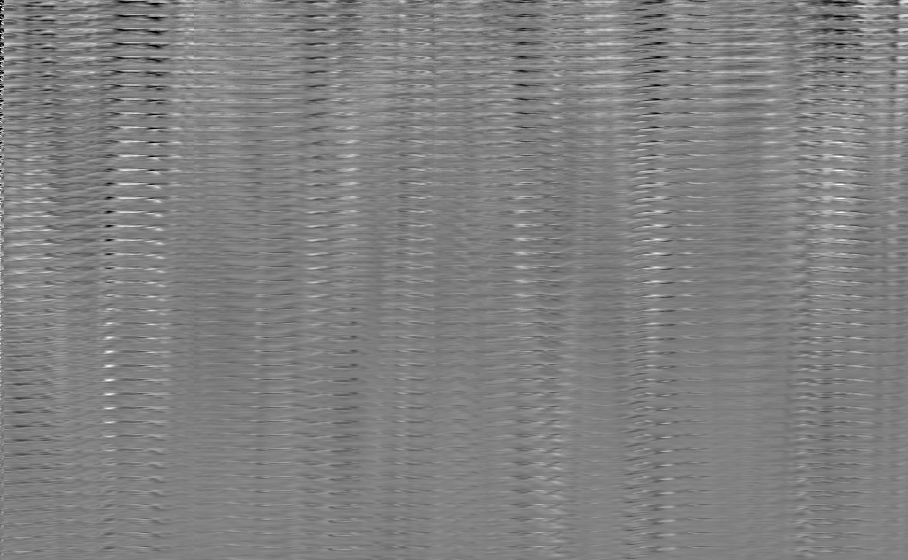

In [35]:
# 4. Inference and Visualization Example
# Select example images
folders = train.FolderName.unique()
example_folder = folders[0]
example_side = 'L'
labels, imgs = get_images_labels(f'{example_folder}_{example_side}_')
stacked_image, _ = prepare_stacked_data(imgs[20:60], labels[20:60])  # Stack first 5 images
stacked_image

In [40]:
# Load trained model
model = YOLO('runs/segment/train/weights/best.pt')  # Adjust path if necessary
metrics = model.val()  
# Perform inference
results = model(stacked_image)
polygons = results[0].masks.xy
visualize(stacked_image, polygons)

Ultralytics 8.3.96  Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
YOLO11l-seg summary (fused): 203 layers, 27,585,363 parameters, 0 gradients, 141.9 GFLOPs


val: Scanning D:\python\manioka\seg\labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47/47 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Lim

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:00<00:01,  1.53it/s]

WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Lim

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:01<00:00,  1.25it/s]

WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Lim

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


                   all         47       1964      0.809      0.604      0.698      0.394      0.395      0.305      0.245      0.109
Speed: 0.3ms preprocess, 39.8ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\segment\val

0: 416x640 37 roots, 63.8ms
Speed: 1.5ms preprocess, 63.8ms inference, 19.2ms postprocess per image at shape (1, 3, 416, 640)


<Figure size 640x480 with 1 Axes>

In [41]:
print(metrics.box.map)

0.3936630173963065


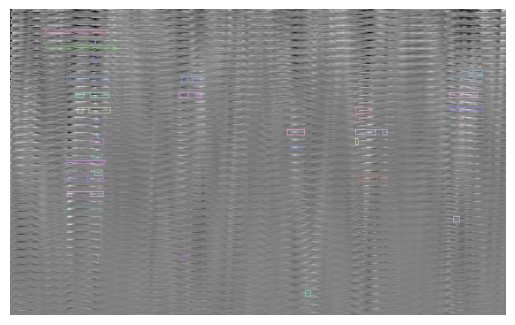

In [45]:
visualize(stacked_image, polygons)